
In this section, we will be using active learning to predict. 

We will be using a dataset that is about product marketing - bank product marketing to be more precise. We want to predict if the client will subscribe to a term deposit. The situation is that customer agents, whose time costs money, will call customers. We need to decide which customers will be most likely to sign up, so we can prioritze the calls. 

This is a nice use case for active learning, because - not unlike in reinforcement learning - uncertainty could be an additional criterion, apart from positive expectation, from a customer. Over time, this entropy-reduction seeking behavior would reduce as the model's understanding of customers improves.

Again we will get the data from OpenML.

In [1]:
pip install -q openml modAL category_encoders

     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 81kB 4.4MB/s 


In [2]:
import openml
dataset = openml.datasets.get_dataset(1461)

In [3]:
X, y, categorical_indicator, _ = dataset.get_data(
    dataset_format='dataframe',
    target=dataset.default_target_attribute
)
categorical_features = X.columns[categorical_indicator]
numeric_features = X.columns[[not(i) for i in categorical_indicator]]

In [4]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,5.0,may,261.0,1.0,-1.0,0.0,unknown
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5.0,may,151.0,1.0,-1.0,0.0,unknown
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5.0,may,76.0,1.0,-1.0,0.0,unknown
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5.0,may,92.0,1.0,-1.0,0.0,unknown
4,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5.0,may,198.0,1.0,-1.0,0.0,unknown


In [5]:
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import category_encoders as ce


def col_names2slices(column_names, X):
    numpy_slice = []
    X_cols = list(X.columns)
    for col in column_names:
        numpy_slice.append(X_cols.index(col))
    return list(numpy_slice)

ordinal_encoder = ce.OrdinalEncoder(
    cols=None,  # all features that it encounters
    handle_missing='return_nan',
    handle_unknown='ignore'
).fit(X)

preprocessor = ColumnTransformer(
    transformers=[
        #('ranges', range_transformer, range_features),
        ('cat', ordinal_encoder, categorical_features),
        ('num', FunctionTransformer(validate=False), numeric_features)]
)

preprocessor = preprocessor.fit(X)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Since we are dealing with an imbalanced dataset, let us use class weights. This basically means that we are upsampling the minority (signing up) class and downsampling the majority class (not signing up). The formula for the class weights is as follows:

$ \text{n_samples} / (\text{n_classes} * \text{np.bincount}(y))$

In [7]:
class_weights = len(X) / (y.astype(int).value_counts() * 2)

Only few models in [sklearn allow incremental or online learning](https://scikit-learn.org/0.15/modules/scaling_strategies.html). A few linear models include the *partial_fit()* method. The Sk-multiflow package specializes in incremental and online/streaming models. Let us try one of their models.

In [8]:
pip install -q scikit-multiflow

     |████████████████████████████████| 1.1MB 2.8MB/s 


In [73]:
import numpy as np
from skmultiflow.trees import HoeffdingTree
from sklearn.metrics import roc_auc_score
from modAL.uncertainty import classifier_uncertainty
import random


class ActivePipeline:
    '''inspired by modAL.models.ActiveLearner
    '''
    def __init__(self, model, preprocessor, class_weights):
        self.model = model
        self.preprocessor = preprocessor
        self.class_weights = class_weights

    @staticmethod
    def values(X):
        if isinstance(X, (np.ndarray, np.int64)):
            return X
        else:
            return X.values

    def preprocess(self, X):
        X_ = pd.DataFrame(
            data=self.values(X),
            columns=['V1', 'V2', 'V3', 'V4',
                     'V5', 'V6', 'V7', 'V8',
                     'V9', 'V10', 'V11',
                     'V12', 'V13', 'V14',
                     'V15', 'V16']
        )
        return self.preprocessor.transform(X_)

    def fit(self, X, ys):
        weights = [self.class_weights[y] for y in ys]
        self.model.fit(self.preprocess(X), self.values(ys))  #, classes=ys.unique(), weight=weights)  # classes

    def update(self, X, ys):
        if isinstance(ys, (int, float)):
            weight = self.class_weights[y]
        else:
            weight = [self.class_weights[y] for y in ys]
        self.model.partial_fit(
            self.preprocess(X),
            self.values(ys),
            weight
        )

    def predict(self, X):
        return self.model.predict(
            self.preprocess(X)
        )

    def predict_proba(self, X):
        return self.model.predict_proba(
            self.preprocess(X)
        )

    def max_margin_uncertainty(self, X, k=100, sample=True):
        '''similar to modAL.uncertainty.margin_uncertainty

        Calculate margin uncertainty based on predicted
        class probabilities, and return the element from
        X that should be learned next based on uncertainties.

        Either randomly sample (weighted by uncertainties) or
        just take the most uncertain element.

        Parameters
        - X - dataset to learn.
        - k - how many points to return.
        - sample - [bool] if to sample by uncertainties or to
          take the most uncertain point(s) from X.

        Returns
        - the index(es) of the points with highest margin uncertainty
        - the average remaining uncertainty
        '''
        probs = self.predict_proba(X)
        uncertainties = 1.0 - np.abs(probs[:,2] - probs[:, 1])
        remaining_uncertainty = float(np.mean(uncertainties))
        if sample:
          inds = random.choices(range(len(X)), uncertainties, k=k)
        else:
          inds = np.flip(np.sort(uncertainties))
        return list(inds), remaining_uncertainty

    def score(self, X, y):
        return roc_auc_score(y, self.predict(X))

In [74]:
active_pipeline = ActivePipeline(HoeffdingTree(), preprocessor, class_weights.to_dict())
active_pipeline.model.classes = [0, 1, 2]
X_all = X.copy().reset_index(drop=True)
y_all = y.copy().reset_index(drop=True).astype(int)

n_initial = len(X) // 10
step_size = 100
sampling = True

print('Assuming {} points are known'.format(n_initial))
initial_idx = np.random.choice(
    len(X_all), size=n_initial, replace=False
)
X_train, y_train = X_all.iloc[initial_idx], y_all.iloc[initial_idx]

active_pipeline.fit(X_train, y_train.astype(int))
X_all = X_all.drop(initial_idx)
y_all = y_all.drop(initial_idx)
N = len(X_all)

/usr/local/lib/python3.6/dist-packages/skmultiflow/trees/hoeffding_tree.py:35: FutureWarning: 'HoeffdingTree' has been renamed to 'HoeffdingTreeClassifier' in v0.5.0.
The old name will be removed in v0.7.0
  "The old name will be removed in v0.7.0", category=FutureWarning)


Assuming 4521 points are known


In [75]:
from collections import namedtuple

Iteration = namedtuple(
    'Iteration',
    ['iteration',
     'score',
     'uncertainty',
     'target']
)

history = []
it = 0
learned = []
score = active_pipeline.score(X, y)
while score < 0.70 and it <= N:
    stream_idx, uncertainty = active_pipeline.max_margin_uncertainty(X_all, sample=sampling, k=step_size)
    print(
        'iteration: ', it, 'score: {:.2f}'.format(score),
        'uncertainty: {:.2f}'.format(uncertainty)
    )
    
    active_pipeline.update(
        np.array(X_all.iloc[stream_idx], ndmin=2),
        np.array(y_all.astype(int).iloc[stream_idx], ndmin=1)
    )
    score = active_pipeline.score(X_all, y_all)
    history.append(
        Iteration(
            iteration=it,
            score=score,
            uncertainty=uncertainty,
            target=y_all.iloc[stream_idx]
        )
    )
    X_all = X_all.drop(X_all.index[stream_idx]).reset_index(drop=True)
    y_all = y_all.drop(y_all.index[stream_idx]).reset_index(drop=True)
    it += 1


iteration:  0 score: 0.55 uncertainty: 0.18
iteration:  1 score: 0.53 uncertainty: 0.15
iteration:  2 score: 0.53 uncertainty: 0.15
iteration:  3 score: 0.53 uncertainty: 0.15
iteration:  4 score: 0.53 uncertainty: 0.15
iteration:  5 score: 0.53 uncertainty: 0.15
iteration:  6 score: 0.53 uncertainty: 0.14
iteration:  7 score: 0.53 uncertainty: 0.15
iteration:  8 score: 0.53 uncertainty: 0.15
iteration:  9 score: 0.53 uncertainty: 0.15
iteration:  10 score: 0.53 uncertainty: 0.15
iteration:  11 score: 0.53 uncertainty: 0.15
iteration:  12 score: 0.53 uncertainty: 0.14
iteration:  13 score: 0.53 uncertainty: 0.14
iteration:  14 score: 0.53 uncertainty: 0.14
iteration:  15 score: 0.53 uncertainty: 0.14
iteration:  16 score: 0.53 uncertainty: 0.14
iteration:  17 score: 0.53 uncertainty: 0.14
iteration:  18 score: 0.53 uncertainty: 0.14
iteration:  19 score: 0.53 uncertainty: 0.14
iteration:  20 score: 0.53 uncertainty: 0.14
iteration:  21 score: 0.53 uncertainty: 0.14
iteration:  22 score

In [78]:
history[1].iteration

1

In [79]:
len(history)

1486

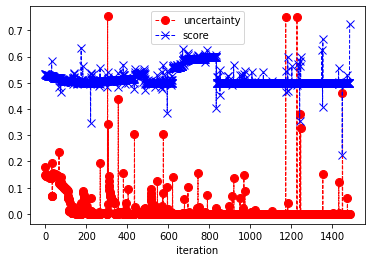

In [80]:
plt.plot(
    [hist.iteration for hist in history if not isinstance(hist, float)],
    [hist.uncertainty for hist in history if not isinstance(hist, float)],
    color='red',
    marker='o',
    linestyle='dashed',
    linewidth=1,
    markersize=8
)
plt.plot(
    [hist.iteration for hist in history if not isinstance(hist, float)],
    [hist.score for hist in history if not isinstance(hist, float)],
    color='blue',
    marker='x',
    linestyle='dashed',
    linewidth=1,
    markersize=8
)

plt.xlabel("iteration")
#plt.ylabel("uncertainty")
plt.legend(["uncertainty", 'score'])
